# Living Income Analysis

## Summary:

In this notebook I perform an analysis about the factors that can predict whether or not a cocoa farming in Ghana and Côte d'Ivoire reach a Living Income.

I use that using as starting point the dataset from the Demystifying the Cocoa study, and build on the work published here and here

In this notebook, specifically I will:
* Load the data
* Do an initial variable and feature selection from the original dataset
* Create the Analytical groups
* Calculate household income, performing data imputation where needed
* Create a variable with the Living Income value per household and an indicator variable on whether this is achieved
* Clean the remainder of the dataset
* Construct a Supervised Learning Machine Learning Model (Classifier) to predict if a household achieves the Living Income

# 0. Initial (Data) processing 

## 0.1 Preamble

First we load all libraries to be used:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA  
from sklearn.cluster import KMeans

from sklearn.impute import SimpleImputer

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import seaborn as sns#; sns.set(style="ticks", color_codes=True)
current_palette = sns.color_palette()

from scipy.stats import variation

import json

## 0.2 Data Import and initial feature  & observation selection

Load the data from stata, which has already been partially cleaned/treated, since it comes from a curated public data repository.

The dataset is extracted from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/82TWZJ
in stata 14 binary format.

It is part of the research project described more broadly at https://www.kit.nl/project/demystifying-cocoa-sector/

In [2]:
data = pd.read_stata("Cocoa_Livelihoods_export_Dataverse.dta") # data
data_properties = pd.read_stata("Cocoa_Livelihoods_export_Dataverse.dta", iterator = True) #meta data

We initialliy inspect the data:

In [3]:
print("Shape of data set:", data.shape)

Shape of data set: (3045, 1252)


First few rows

In [4]:
data.head(10)

,today,country,region_comparable,up_region,region,sub_region,village,latitude,longitude,consent_yn,...,foodsec_bin_3,foodsec_bin_4,foodsec_bin_5,foodsec_bin_6,foodsec_bin_7,foodsec_bin_8,foodsec_bin_9,foodsec_bin_10,foodsec_bin_11,foodsec_bin_12
0,26-dec-16,Ghana,Ashanti,Ghana,Ashanti,Atwima Mponua,Agogoso,6.61,-2.07,yes,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
1,27-dec-16,Ghana,Ashanti,Ghana,Ashanti,Atwima Nwabiagya,Toase,NaN,NaN,yes,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
2,04-dec-16,Ghana,Ashanti,Ghana,Ashanti,Adansi West,Ampunyasi,6.04,-1.76,yes,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
3,03-dec-16,Ghana,Ashanti,Ghana,Ashanti,Bosomtwi Kwanwoma,Nyameani,NaN,NaN,yes,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
4,03-dec-16,Ghana,Ashanti,Ghana,Ashanti,Bosomtwi Kwanwoma,Nyameani,6.57,-1.43,yes,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
5,2-dec-2016,Ghana,Ashanti,Ghana,Ashanti,Adansi East,Aboabo 2,6.22,-1.35,yes,...,no,no,yes,yes,yes,yes,yes,yes,yes,yes
6,03-dec-16,Ghana,Ashanti,Ghana,Ashanti,Bosomtwi Kwanwoma,Nyameani,6.57,-1.43,yes,...,no,no,no,no,no,no,no,no,no,no
7,27-dec-16,Ghana,Ashanti,Ghana,Ashanti,Atwima Nwabiagya,Toase,6.66,-1.81,yes,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
8,29-dec-16,Ghana,Ashanti,Ghana,Ashanti,Afigya Sekyere,Jamaase,NaN,NaN,yes,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
9,04-dec-16,Ghana,Ashanti,Ghana,Ashanti,Adansi West,Ampunyasi,6.04,-1.76,yes,...,no,no,no,no,yes,yes,yes,no,yes,yes


See some descriptive statistics

In [5]:
data.describe()

,latitude,longitude,hhmem_number,male_adults_over_65,female_adults_over_65,male_adults_15_65,female_adults_15_65,male_children_5_14,female_children_5_14,male_children_0_4,...,dhs_combined,PPI_SCORE,PPI_100_Nat,PPI_125dollar_day,PPI_200dollar_day,PPI_250dollar_day,PPI_190dollar_day,PPI_310dollar_day,non_cocoa_land,share_cocoa_land
count,2210.000000,2210.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000,...,2435.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,1545.000000,1545.000000,1887.000000,1887.000000
mean,6.429661,-4.112733,6.264314,0.142144,0.147803,1.689747,1.705726,0.981025,0.868842,0.374501,...,-0.291392,44.137032,30.232420,14.947255,33.256577,44.436817,7.543701,24.523375,1.705683,0.732727
std,0.697673,1.894443,3.200178,0.374114,0.402447,1.247421,1.181760,1.123111,1.099499,0.681247,...,0.487034,13.002094,22.378967,16.871199,28.074274,31.169250,9.881251,20.898497,2.309870,0.238368
min,4.840000,-8.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.672072,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632
25%,5.940000,-5.447500,4.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,-0.605459,35.000000,11.700000,0.600000,5.300000,12.800000,0.900000,5.800000,0.000000,0.555556
50%,6.470000,-3.870000,6.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,-0.363614,43.000000,28.900000,7.200000,27.100000,41.299999,2.400000,16.100000,0.980000,0.750000
75%,6.930000,-2.500000,8.000000,0.000000,0.000000,2.000000,2.000000,2.000000,1.000000,1.000000,...,-0.055659,53.000000,50.700001,27.100000,59.400002,74.099998,7.900000,35.400002,2.296600,1.000000
max,7.840000,-0.470000,21.000000,5.000000,5.000000,9.000000,9.000000,7.000000,7.000000,5.000000,...,2.926933,98.000000,87.599998,71.500000,93.900002,97.199997,50.700001,81.699997,17.000000,1.000000


Take a look at the full list of variables and variable labels:

In [6]:
print(json.dumps(data_properties.variable_labels(), indent=1))

{
 "today": "Interview date",
 "country": "Country",
 "region_comparable": "Comparable regions",
 "up_region": "Country (Ghana) / District (CdI)",
 "region": "Region",
 "sub_region": "District (Ghana) / Departement (Cdi)",
 "village": "Village",
 "latitude": "Latitude",
 "longitude": "Longitude",
 "consent_yn": "Consent to participate",
 "hhmem_number": "Number of household members living in the compound",
 "male_adults_over_65": "Number of males over 65 years old",
 "female_adults_over_65": "Number of females over 65 years old",
 "male_adults_15_65": "Number of males 15-65",
 "female_adults_15_65": "Number of females between 15 and 65 years old",
 "male_children_5_14": "Number of boys between 15 and 65 years old",
 "female_children_5_14": "Number of girls  between 5 and 14 years old",
 "male_children_0_4": "Number of boys younger than 4 years old",
 "female_children_0_4": "Number of girls younger than 4 years old",
 "dep_ratio": "Dependency ratio",
 "head_age": "Head: age",
 "head_age

The full dataset has (too) many features (1252), in comparison to the number of observations. 

This includes features which are not useful for the analysis, and some are sets of dummy variables (which is fine).

I will initially drop features that I know I will not be needing for any of the analysis.

They include:
- location variables, except country. Analysis will be on a country level
- consent indicator, as this should be 'yes' for all observations included in this dataset
- instanceid, unique identifier
- data on the respondent (data on the head of the household and on the full household will suffice)
- variables in imputed values ("fm_"), since the imputation was done based on the country level, and I will do this by other 
groups
- variables with the profit and value of production, since these will be re-calculated here
- details on the price, since only the common price per kg in USD will be used
- indicator of selling crops for the subset of those that produced: this variable carries by construction many missing values (those that did not produce) and therefore is not of interest
- variables with daily rates for hired labour, since the original reports refer they used median hiring cost to adjust for noise in the responses
- question on the "(days)known" for labour activities or other detailed, since these are intermediary variables to filter on the amount of days and therefore not needed for this analysis
- land unit prefence, since all is already converted into ha


Confirm `consent` is `yes` for all obs

In [7]:
data['consent_yn'].value_counts()

yes    3045
Name: consent_yn, dtype: int64

In [8]:
data.drop(['region_comparable', 'up_region', 'sub_region', 'village', 'latitude', 'longitude'], axis = 1, inplace = True) # drop location variables
data.drop(['today','consent_yn', 'instanceid', 'land_unit_preference'], axis = 1, inplace = True) # drop id variables
data.drop(list(data.filter(regex = 'p1_')), axis = 1, inplace = True) # drop respondent variables
data.drop(['age_cat', 'leader'], axis = 1, inplace = True) # drop id variables
data.drop(list(data.filter(regex = 'fm_')), axis = 1, inplace = True) # drop farm model imputed variables
data.drop(['cocoa_price_common_usdkg','cocoa_price_highest_usdkg','cocoa_price_lowest_usdkg'], axis = 1, inplace = True) # drop farm model imputed variables
data.drop(['cocoa_valueproduction_usd','cocoa_valueproduction_usd_ha','cocoa_profit1_usdha','cocoa_profit2_usdha'], axis = 1, inplace = True) # drop farm model imputed variables
data.drop(list(data.filter(regex = 'crops_sold_ifprod')), axis = 1, inplace = True) # drop indicator subset for farmers that did produce a crop
data.drop(list(data.filter(regex = 'orig_hi_cost')), axis = 1, inplace = True) # drop farm model imputed variables
#data.drop(list(data.filter(regex = 'known_yn')), axis = 1, inplace = True) # drop farm model imputed variables
data.drop(list(data.filter(regex = 'days_known_yn')), axis = 1, inplace = True) # drop farm model imputed variables

For each production activity there is also two sex of workers indicators (`_gender_1, _gender_2`), plus a combined indicator (`_gender`). I can drop the latter.

In [9]:
list(data.filter(regex = 'gender'))

['head_gender',
 'cocoa_landclear_gender_1',
 'cocoa_landclear_gender_2',
 'cocoa_landclear_gender',
 'cocoa_landprep_gender_1',
 'cocoa_landprep_gender_2',
 'cocoa_landprep_gender',
 'cocoa_planting_gender_1',
 'cocoa_planting_gender_2',
 'cocoa_planting_gender',
 'cocoa_gfert_gender_1',
 'cocoa_gfert_gender_2',
 'cocoa_gfert_gender',
 'cocoa_lfert_gender_1',
 'cocoa_lfert_gender_2',
 'cocoa_lfert_gender',
 'cocoa_manurecomp_gender_1',
 'cocoa_manurecomp_gender_2',
 'cocoa_manurecomp_gender',
 'cocoa_herb_gender_1',
 'cocoa_herb_gender_2',
 'cocoa_herb_gender',
 'cocoa_pest_gender_1',
 'cocoa_pest_gender_2',
 'cocoa_pest_gender',
 'cocoa_fung_gender_1',
 'cocoa_fung_gender_2',
 'cocoa_fung_gender',
 'cocoa_weed_gender_1',
 'cocoa_weed_gender_2',
 'cocoa_weed_gender',
 'cocoa_pruning_gender_1',
 'cocoa_pruning_gender_2',
 'cocoa_pruning_gender',
 'cocoa_harvest_gender_1',
 'cocoa_harvest_gender_2',
 'cocoa_harvest_gender',
 'cocoa_podbreak_gender_1',
 'cocoa_podbreak_gender_2',
 'cocoa

In [10]:
data.drop([
 'cocoa_landclear_gender',
 'cocoa_landprep_gender',
 'cocoa_planting_gender',
 'cocoa_gfert_gender',
 'cocoa_lfert_gender',
 'cocoa_manurecomp_gender',
 'cocoa_herb_gender',
 'cocoa_pest_gender',
 'cocoa_fung_gender',
 'cocoa_weed_gender',
 'cocoa_pruning_gender',
 'cocoa_harvest_gender',
 'cocoa_podbreak_gender',
 'cocoa_ferment_gender',
 'cocoa_transport_gender',
 'cocoa_decisions_gender',
 'cocoa_marketing_gender'
], axis = 1, inplace = True)

Similarly, for each production activity there is also four types of workers indicators (`hhhiredcom_`), plus a combined indicator (`hh_hi`). I can drop the latter.

In [11]:
data.drop(list(data.filter(regex = 'hh_hi')), axis = 1, inplace = True) # drop respondent variables

There are 3 sets of features about the allocation of production: in kg, in kg/ha and as share of total. I'll keep only the one on shares.

In [12]:
data.drop([
 'cocoa_sold_kg',
 'cocoa_sold_kgha',
 'cocoa_consumed_kg',
 'cocoa_consumed_kgha',
 'cocoa_oblig_kg',
 'cocoa_oblig_kgha',
 'cocoa_givenaway_kg',
 'cocoa_givenaway_kgha',
 'cocoa_barterexchange_kg',
 'cocoa_barterexchange_kgha',
 'cocoa_givenforlabour_kg',
 'cocoa_givenforlabour_kgha',
 'cocoa_lost_kg',
 'cocoa_lost_kgha'
], axis = 1, inplace = True)

For the analysis, I will only look at cocoa households that know their land and production

In [13]:
data = data[data['cocoa_hh']=='yes']
data = data[data['cocoa_land_known_yn']=='yes']
data = data[data['cocoa_prod_known_yn']=='yes']

In [14]:
data = data[data['cocoa_prod_total_kgsha'].notnull()]

In [15]:
data.drop(['cocoa_hh', 'cocoa_land_known_yn'], axis = 1, inplace = True)

Further, for this analysis, I'm only interested in the total production over an year, and not disaggregated into seasons

In [16]:
data.drop([
    'cocoa_season1_start',
    'cocoa_season1_end',
    'cocoa_season2_start',
    'cocoa_season2_end',
    'cocoa_prod_season1_kg',
    'cocoa_prod_season1_kgha',
    'cocoa_prod_season2_kg',
    'cocoa_prod_season2_kgha'
], axis = 1, inplace = True)

Now we can also drop some of the other household type indicators, since we are only looking at cocoa households

In [17]:
list(data.filter(regex = '_hh'))

['coconut_hh',
 'cocoyam_hh',
 'coffee_hh',
 'courgette_hh',
 'cotton_hh',
 'cow_pea_hh',
 'eggplant_hh',
 'fodder_hh',
 'garlic_hh',
 'ginger_hh',
 'groundnuts_hh',
 'lemon_hh',
 'lime_hh',
 'maize_hh',
 'mango_hh',
 'millet_hh',
 'okra_hh',
 'onions_hh',
 'oranges_hh',
 'palm_hh',
 'papaya_hh',
 'peas_hh',
 'peppers_hh',
 'pineapple_hh',
 'plantai_hh',
 'irish_potato_hh',
 'sweet_potato_hh',
 'rice_hh',
 'rubber_hh',
 'spinach_hh',
 'sorghum_hh',
 'shea_nut_hh',
 'sugar_cane_hh',
 'tangerine_hh',
 'tomatoes_hh',
 'watermelon_hh',
 'yam_hh',
 'avocado_hh_5ago',
 'bananas_hh_5ago',
 'soya_beans_hh_5ago',
 'beans_hh_5ago',
 'cabbages_hh_5ago',
 'carrots_hh_5ago',
 'cashews_hh_5ago',
 'cassava_hh_5ago',
 'chili_hh_5ago',
 'cocoa_hh_5ago',
 'coconut_hh_5ago',
 'cocoyam_hh_5ago',
 'coffee_hh_5ago',
 'courgette_hh_5ago',
 'cotton_hh_5ago',
 'cow_pea_hh_5ago',
 'eggplant_hh_5ago',
 'fodder_hh_5ago',
 'garlic_hh_5ago',
 'ginger_hh_5ago',
 'groundnuts_hh_5ago',
 'lemon_hh_5ago',
 'lime_hh_5ago

In [18]:
data.drop(
['coconut_hh',
 'cocoyam_hh',
 'coffee_hh',
 'courgette_hh',
 'cotton_hh',
 'cow_pea_hh',
 'eggplant_hh',
 'fodder_hh',
 'garlic_hh',
 'ginger_hh',
 'groundnuts_hh',
 'lemon_hh',
 'lime_hh',
 'maize_hh',
 'mango_hh',
 'millet_hh',
 'okra_hh',
 'onions_hh',
 'oranges_hh',
 'palm_hh',
 'papaya_hh',
 'peas_hh',
 'peppers_hh',
 'pineapple_hh',
 'plantai_hh',
 'irish_potato_hh',
 'sweet_potato_hh',
 'rice_hh',
 'rubber_hh',
 'spinach_hh',
 'sorghum_hh',
 'shea_nut_hh',
 'sugar_cane_hh',
 'tangerine_hh',
 'tomatoes_hh',
 'watermelon_hh',
 'yam_hh',
 'avocado_hh_5ago',
 'bananas_hh_5ago',
 'soya_beans_hh_5ago',
 'beans_hh_5ago',
 'cabbages_hh_5ago',
 'carrots_hh_5ago',
 'cashews_hh_5ago',
 'cassava_hh_5ago',
 'chili_hh_5ago',
 'cocoa_hh_5ago',
 'coconut_hh_5ago',
 'cocoyam_hh_5ago',
 'coffee_hh_5ago',
 'courgette_hh_5ago',
 'cotton_hh_5ago',
 'cow_pea_hh_5ago',
 'eggplant_hh_5ago',
 'fodder_hh_5ago',
 'garlic_hh_5ago',
 'ginger_hh_5ago',
 'groundnuts_hh_5ago',
 'lemon_hh_5ago',
 'lime_hh_5ago',
 'maize_hh_5ago',
 'mango_hh_5ago',
 'millet_hh_5ago',
 'okra_hh_5ago',
 'onions_hh_5ago',
 'oranges_hh_5ago',
 'palm_hh_5ago',
 'papaya_hh_5ago',
 'peas_hh_5ago',
 'peppers_hh_5ago',
 'pineapple_hh_5ago',
 'plantai_hh_5ago',
 'irish_potato_hh_5ago',
 'sweet_potato_hh_5ago',
 'rice_hh_5ago',
 'rubber_hh_5ago',
 'spinach_hh_5ago',
 'sorghum_hh_5ago',
 'shea_nut_hh_5ago',
 'sugar_cane_hh_5ago',
 'tangerine_hh_5ago',
 'tomatoes_hh_5ago',
 'watermelon_hh_5ago',
 'yam_hh_5ago',
 'avocado_hh_change',
 'bananas_hh_change',
 'soya_beans_hh_change',
 'beans_hh_change',
 'cabbages_hh_change',
 'carrots_hh_change',
 'cashews_hh_change',
 'cassava_hh_change',
 'chili_hh_change',
 'cocoa_hh_change',
 'coconut_hh_change',
 'cocoyam_hh_change',
 'coffee_hh_change',
 'courgette_hh_change',
 'cotton_hh_change',
 'cow_pea_hh_change',
 'eggplant_hh_change',
 'fodder_hh_change',
 'garlic_hh_change',
 'ginger_hh_change',
 'groundnuts_hh_change',
 'lemon_hh_change',
 'lime_hh_change',
 'maize_hh_change',
 'mango_hh_change',
 'millet_hh_change',
 'okra_hh_change',
 'onions_hh_change',
 'oranges_hh_change',
 'palm_hh_change',
 'papaya_hh_change',
 'peas_hh_change',
 'peppers_hh_change',
 'pineapple_hh_change',
 'plantai_hh_change',
 'irish_potato_hh_change',
 'sweet_potato_hh_change',
 'rice_hh_change',
 'rubber_hh_change',
 'spinach_hh_change',
 'sorghum_hh_change',
 'shea_nut_hh_change',
 'sugar_cane_hh_change',
 'tangerine_hh_change',
 'tomatoes_hh_change',
 'watermelon_hh_change',
 'yam_hh_change']
, axis = 1, inplace = True)

In [19]:
print("Shape of data set:", data.shape)

Shape of data set: (1455, 875)


Check the distribution across countries:

In [20]:
data['country'].value_counts()

Ghana    1008
CdI       447
Name: country, dtype: int64

## 0.3 Analytical Groups

In line with the Gap Analysis studies, I will create 3 groups per country:

* Female-headed
* Male-headed, typical: Productive cocoa land up to 4 ha
* Male-headed, large: Productive cocoa land larger than  4ha

In [21]:
data.loc[(data['head_gender'] == 'female') & (data['country'] == 'Ghana') , 'Analytical Group'] = 'Ghana: Female-headed'
data.loc[(data['head_gender'] == 'male'  ) & (data['country'] == 'Ghana') & (data['cocoa_land_used_morethan5_ha']<=4), 'Analytical Group'] = 'Ghana: Male-headed, typical'
data.loc[(data['head_gender'] == 'male'  ) & (data['country'] == 'Ghana') & (data['cocoa_land_used_morethan5_ha']>4 ), 'Analytical Group'] = 'Ghana: Male-headed, large'

data.loc[(data['head_gender'] == 'female') & (data['country'] == 'CdI' ) , 'Analytical Group'] = 'CdI: Female-headed'
data.loc[(data['head_gender'] == 'male'  ) & (data['country'] == 'CdI' ) & (data['cocoa_land_used_morethan5_ha']<=4), 'Analytical Group'] = 'CdI: Male-headed, typical'
data.loc[(data['head_gender'] == 'male'  ) & (data['country'] == 'CdI' ) & (data['cocoa_land_used_morethan5_ha']>4 ), 'Analytical Group'] = 'CdI: Male-headed, large'

Check:

In [22]:
data['Analytical Group'].value_counts()

Ghana: Male-headed, typical    627
CdI: Male-headed, typical      313
Ghana: Male-headed, large      219
Ghana: Female-headed           162
CdI: Male-headed, large        119
CdI: Female-headed              15
Name: Analytical Group, dtype: int64

Because the group `CdI: Female-headed` is too small (_N = 15_) I will remove it from the analysis

In [23]:
data = data[data['Analytical Group']!='CdI: Female-headed']

# 1. Calculating the total income

## 1.1 Introduction

We calculate the total household income as:

_Total Household Income = (net cocoa income)/(income share from cocoa)_

In other words, we calculate the net cocoa income, and extrapolate the household income by using the information on the share of total income coming from cocoa

Te _net cocoa income_ is calculated as:

_net cocoa_income = (total production (kg/ha) * price (USD/kg) - input costs (USD/ha) - labor costs (USD/ha))* Productive land (ha)_

To calculate input costs and labor costs we need to go over the different input types and production activities

## 1.2 Calculating income components

The detailed cocoa production features are built over a few production activities, types of labor and inputs. We will create lists with those activities, types of labor and inputs for further iteration in this notebook.

In [24]:
production_activities = [
    'landclear',
    'landprep',
    'planting',
    'gfert',
    'lfert',
    'manurecomp',
    'herb',
    'pest',
    'fung',
    'weed',
    'pruning',
    'harvest',
    'podbreak',
    'ferment',
    'transport',
    'dry'
]

types_of_labor = [
    'hi_n_ha',
    'hh_n_ha',
    'com_n_ha',
    'lab_n_ha',
    'hi_lab_usdha'
]

inputs = [
    'gfert',
    'lfert',
    'herb',
    'pest',
    'fung'
]

Let's first check if these variables have missing values. We look at the `hi_lab_usdha` features, since this is directly relevant for the calculations:

In [25]:
data.filter(regex = 'hi_lab_usdha').describe()

,cocoa_landclear_hi_lab_usdha,cocoa_landprep_hi_lab_usdha,cocoa_planting_hi_lab_usdha,cocoa_gfert_hi_lab_usdha,cocoa_lfert_hi_lab_usdha,cocoa_manurecomp_hi_lab_usdha,cocoa_herb_hi_lab_usdha,cocoa_pest_hi_lab_usdha,cocoa_fung_hi_lab_usdha,cocoa_weed_hi_lab_usdha,cocoa_pruning_hi_lab_usdha,cocoa_harvest_hi_lab_usdha,cocoa_podbreak_hi_lab_usdha,cocoa_transport_hi_lab_usdha
count,1214.000000,1177.000000,848.000000,1063.000000,1150.000000,858.000000,1041.000000,969.000000,963.000000,732.000000,598.000000,662.000000,641.000000,932.000000
mean,4.767475,1.937751,1.512467,1.013818,4.178011,0.297832,3.168064,9.601581,3.686724,35.093170,7.842022,13.991180,1.790963,4.574852
std,14.252471,10.797291,7.526702,4.708241,12.450053,2.725615,13.565760,17.745373,11.614023,54.913971,18.787256,30.327866,8.157135,12.273155
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.980000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.620000,0.000000,50.590759,0.000000,15.488146,0.000000,2.988000
max,129.067871,160.617813,90.347519,51.627155,99.382263,38.720364,142.297333,116.161095,103.254311,322.669739,125.406960,206.508606,82.280777,103.254303


As expected these features have missing values, in different levels. As the previous study explain, this happens when farmers know they did some activity, but did not know the exact costs. 

My strategy will be to fill this missing values with the median values (per ha) for the farmers that did the activity and could specify the costs. I will do this per analytical group.

In [86]:
def fill_na_by_group(df, yn_feature, feature, group_feature, strategy = 'median'):
    '''
    fills missing values in given feature with the group median (default) or mean value
        
    
    INPUT:
        df: panda DataFrame
        yn_feature: colname to be used to filter = yes
        feature: colname to be filled
        group_feature: feature identifying the different groups
        
    OUTPUT:
        df: modified DataFrame
    '''
    # apply a split-transform action:
    if strategy == 'median':
        df[feature] = df.groupby(group_feature)[feature].transform(lambda col: col.fillna(col.median()))
    elif strategy == 'mean':
        df[feature] = df.groupby(group_feature)[feature].transform(lambda col: col.fillna(col.mean()))
    else:
        raise SyntaxError('Strategy unknown')
        
    # return modified DataFrame
    return df

In [87]:
# iterate through all types of labor
for labor_type in types_of_labor:
    
    # find all columns with that labor type
    full_list = list(data.filter(regex = labor_type))
    
    # apply the fill_na_by_group to each of these columns
    for col in full_list:
        yn_feature = col.replace(labor_type,'yn')
        data = fill_na_by_group(data, yn_feature, col, 'Analytical Group')

KeyError: 'Analytical Group'

Check to be sure it worked as expected:

In [28]:
data.filter(regex = 'hi_lab_usdha').describe()

,cocoa_landclear_hi_lab_usdha,cocoa_landprep_hi_lab_usdha,cocoa_planting_hi_lab_usdha,cocoa_gfert_hi_lab_usdha,cocoa_lfert_hi_lab_usdha,cocoa_manurecomp_hi_lab_usdha,cocoa_herb_hi_lab_usdha,cocoa_pest_hi_lab_usdha,cocoa_fung_hi_lab_usdha,cocoa_weed_hi_lab_usdha,cocoa_pruning_hi_lab_usdha,cocoa_harvest_hi_lab_usdha,cocoa_podbreak_hi_lab_usdha,cocoa_transport_hi_lab_usdha
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,4.019247,1.583843,0.890675,0.748395,3.336607,0.177459,2.290246,7.040217,2.465497,29.317022,3.256618,8.575407,0.797227,2.960946
std,13.199969,9.789679,5.822273,4.069307,11.250765,2.108421,11.619650,15.168522,9.653276,40.911633,12.703491,21.667908,5.512402,10.111212
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.517061,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.604526,0.000000,27.457909,0.000000,8.717306,0.000000,0.000000
max,129.067871,160.617813,90.347519,51.627155,99.382263,38.720364,142.297333,116.161095,103.254311,322.669739,125.406960,206.508606,82.280777,103.254303


I can now calculate the total hired labor costs

In [29]:
data['Cocoa hired labour costs (USD/ha)'] = data.filter(regex = 'hi_lab_usdha').sum(axis = 1)

I use a similar strategy for the input costs:

In [30]:
inputcosts_extended_list = ['cocoa_' + this_input + '_usdha' for this_input in inputs]
data[inputcosts_extended_list].describe()

,cocoa_gfert_usdha,cocoa_lfert_usdha,cocoa_herb_usdha,cocoa_pest_usdha,cocoa_fung_usdha
count,1416.000000,1405.000000,1363.000000,1348.000000,1369.000000
mean,8.633907,2.848809,7.123010,17.830339,2.592730
std,35.850471,9.368103,11.274213,22.563593,6.736555
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,10.755658,0.000000
75%,0.000000,0.000000,12.019188,25.813578,0.000000
max,464.644409,77.440727,67.115295,136.660110,53.119999


In [31]:
# iterate through all input costs
for col in inputcosts_extended_list:
    data = fill_na_by_group(data, col, 'Analytical Group')

Check

In [32]:
data[inputcosts_extended_list].describe()

,cocoa_gfert_usdha,cocoa_lfert_usdha,cocoa_herb_usdha,cocoa_pest_usdha,cocoa_fung_usdha
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,8.490008,2.779567,6.849327,17.413872,2.464894
std,35.568016,9.263855,11.035290,21.893940,6.592160
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,11.066667,0.000000
75%,0.000000,0.000000,11.212773,24.879286,0.000000
max,464.644409,77.440727,67.115295,136.660110,53.119999


Now I can also calculate the total input costs:

In [33]:
data['Cocoa input costs (USD/ha)'] = data[inputcosts_extended_list].sum(axis = 1)

## 1.3 Value adjustments over time

Since a main goal of this analysis is to compare total incomes with the Living Income Benchmark value, they need to be comparable in purchasing power. The Living Income Benchmark values refer to Q1 2018 (Ghana) and Q2 2018 (Côte d'Ivoire). This data, on the other hand, refers to Q1 2016. Therefore I will use a [CPI correction factor](http://data.imf.org/regular.aspx?key=61545849) to bring the survey data from 2016 to 2018 values

In [34]:
# CPI Correction

# Ghana CPI in 2018 Q1: 247.05
# Ghana CPI in 2016 Q1: 197.77
# Living Income  CEDI to USD = 1/4.45 // March 1st 2018
# Survey data CEDI to USD = 0.26116 // Jan 15th, 2016
correction_factor_ghana = (1/0.26116)/197.77*247.05/4.45


# CdI CPI in 2018 Q2: 112.92
# CdI CPI in 2016 Q1: 111.35
# Living Income CFA to USD = 1/576.81 // August 2018
# Survey data CFA to USD = 0.00166 // Jan 16th, 2016
correction_factor_cdi = (1/0.00166)/111.35*112.92/576.81


Apply the correction factor all variables in USD:

In [35]:
usd_list = data.filter(regex = "usd").columns
usd_list = usd_list.append(data.filter(regex = "USD").columns)

In [36]:
data.loc[data['country'] == 'Ghana', usd_list] = data.loc[data['country'] == 'Ghana', usd_list]*correction_factor_ghana
data.loc[data['country'] == 'CdI', usd_list] = data.loc[data['country'] == 'CdI', usd_list]*correction_factor_cdi

# 1.4 Total household income estimation

Finally I will check if all households have estimated share of income coming from cocoa:

In [37]:
data['hh_income_perc_cocoa'].describe()

count    1438.000000
mean        0.628803
std         0.214800
min         0.000000
25%         0.500000
50%         0.600000
75%         0.800000
max         1.000000
Name: hh_income_perc_cocoa, dtype: float64

In [38]:
data['hh_income_perc_cocoa'].isnull().sum()

2

I will also fill these missing values with the group median

In [39]:
data = fill_na_by_group(data, 'hh_income_perc_cocoa', 'Analytical Group')

I also need to drop observations where the share is 0%

In [40]:
data = data[data['hh_income_perc_cocoa']>0]

Now we can compute total household income:

In [41]:
data['Estimated total household income (USD/household/year)'] = (
    (
        + data['cocoa_prod_total_kgsha']*data['cocoa_price_usdkg'] 
        - data['Cocoa input costs (USD/ha)']
        - data['Cocoa hired labour costs (USD/ha)']
    )*data['cocoa_land_used_morethan5_ha'] 
    /data['hh_income_perc_cocoa']
)

Let's check:

In [42]:
data['Estimated total household income (USD/household/year)'].describe()

count     1434.000000
mean      3233.177490
std       3875.258789
min     -16244.933594
25%       1033.287262
50%       2039.838806
75%       4033.521606
max      49948.113281
Name: Estimated total household income (USD/household/year), dtype: float64

Let's drop observations where the total household income is smaller than 0 (likely due to erros in the other variables) 

In [43]:
data = data[data['Estimated total household income (USD/household/year)']>0]

Let's also drop observations that have income values more than 4 standard deviations above the mean

In [44]:
upper_limit = data['Estimated total household income (USD/household/year)'].mean() + data['Estimated total household income (USD/household/year)'].std()*4

while data['Estimated total household income (USD/household/year)'].max() > upper_limit:
    data = data[data['Estimated total household income (USD/household/year)']<=upper_limit]
    upper_limit = data['Estimated total household income (USD/household/year)'].mean() + data['Estimated total household income (USD/household/year)'].std()*4

## 1.5 Exploration of total household income

Let's check basic descriptives:

In [45]:
data.groupby('country')['Estimated total household income (USD/household/year)'].describe()

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Ghana,967.0,2821.191895,2498.124756,3.662798,1082.894043,1964.481445,3787.159546,12910.607422
CdI,406.0,2962.629639,2685.554688,18.753244,995.424026,2158.577271,3942.752258,12826.139648


In [46]:
data.groupby('Analytical Group')['Estimated total household income (USD/household/year)'].describe()

,count,mean,std,min,25%,50%,75%,max
Analytical Group,,,,,,,,
"CdI: Male-headed, large",100.0,4979.964844,3153.491455,399.092651,2557.030151,4292.736572,7280.803101,12826.139648
"CdI: Male-headed, typical",306.0,2303.370605,2139.770020,18.753244,855.932037,1751.853882,2853.560669,11351.577148
Ghana: Female-headed,153.0,1799.333496,1862.175659,3.662798,571.482849,1168.973999,2268.604492,11065.551758
"Ghana: Male-headed, large",197.0,5178.709473,3138.082275,320.981140,2598.342285,4871.795410,7256.247070,12439.381836
"Ghana: Male-headed, typical",617.0,2321.860107,1873.747314,18.265448,1058.292603,1778.605347,3025.280273,12910.607422


Lets plot some histograms:

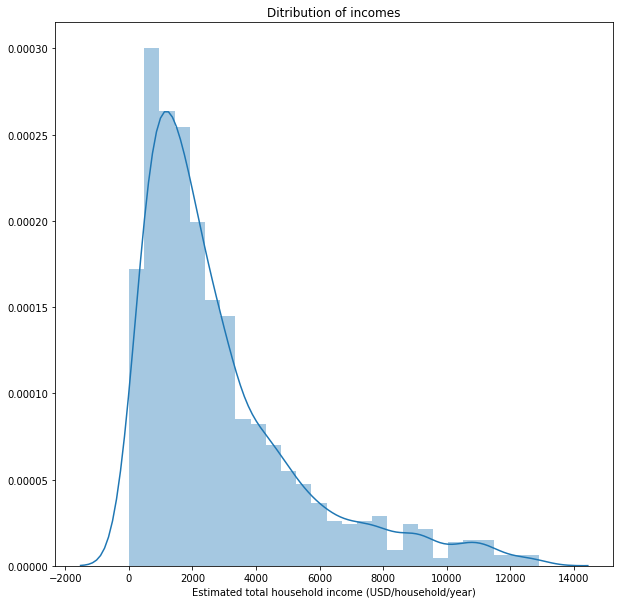

In [47]:
plt.figure(figsize=(10,10))
plt.title ('Ditribution of incomes')
sns.distplot(data['Estimated total household income (USD/household/year)']);

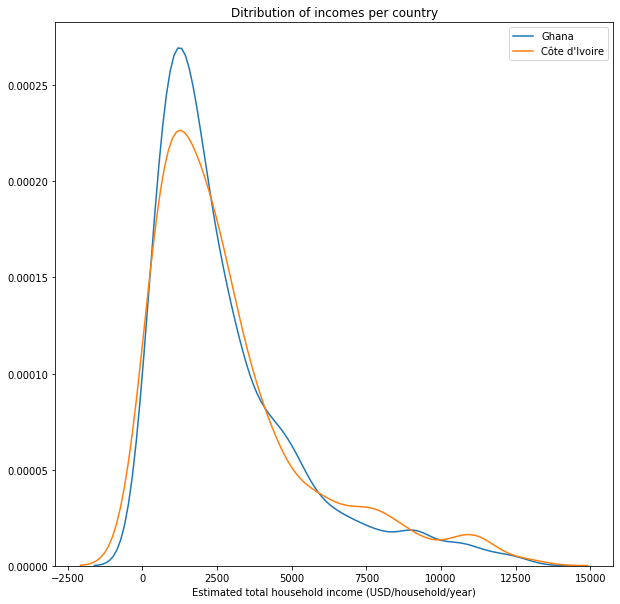

In [48]:
plt.figure(figsize=(10,10))
plt.title ('Ditribution of incomes per country')
sns.distplot(data[data['country']=='Ghana']['Estimated total household income (USD/household/year)'], hist = False, label = 'Ghana');
sns.distplot(data[data['country']=='CdI']['Estimated total household income (USD/household/year)'], hist = False, label = 'Côte d\'Ivoire');

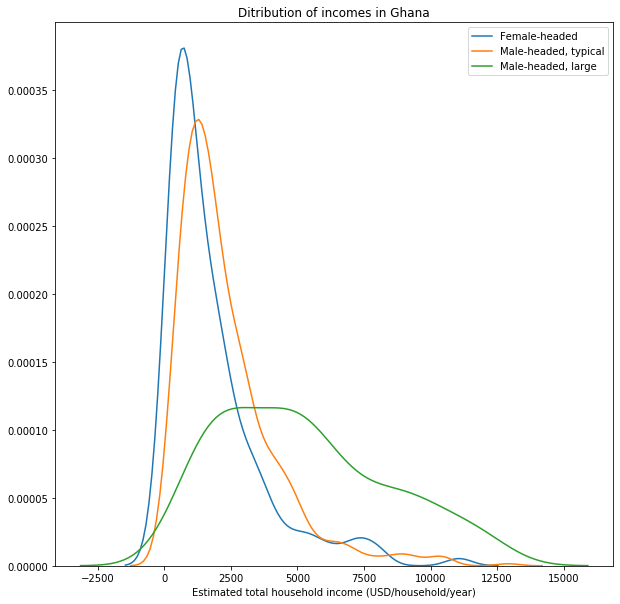

In [49]:
plt.figure(figsize=(10,10))
plt.title ('Ditribution of incomes in Ghana')
sns.distplot(data[data['Analytical Group']=='Ghana: Female-headed']['Estimated total household income (USD/household/year)'], hist = False, label = 'Female-headed');
sns.distplot(data[data['Analytical Group']=='Ghana: Male-headed, typical']['Estimated total household income (USD/household/year)'], hist = False, label = 'Male-headed, typical')
sns.distplot(data[data['Analytical Group']=='Ghana: Male-headed, large']['Estimated total household income (USD/household/year)'], hist = False, label = 'Male-headed, large');


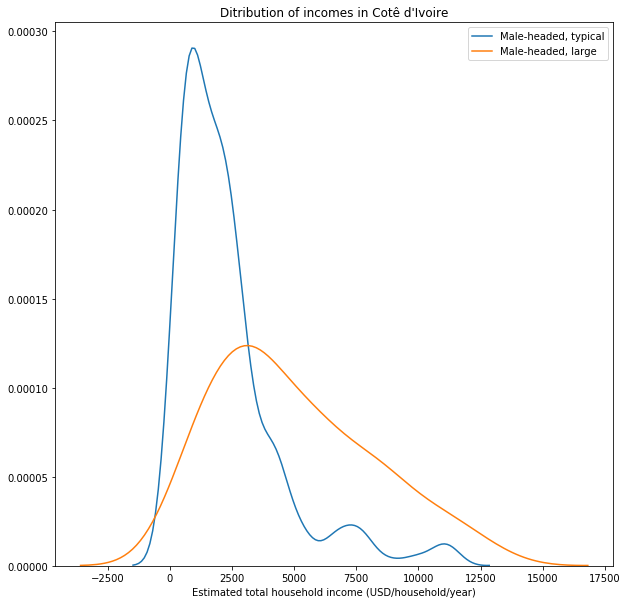

In [50]:
plt.figure(figsize=(10,10))
plt.title ('Ditribution of incomes in Cotê d\'Ivoire')
sns.distplot(data[data['Analytical Group']=='CdI: Male-headed, typical']['Estimated total household income (USD/household/year)'], hist = False, label = 'Male-headed, typical')
sns.distplot(data[data['Analytical Group']=='CdI: Male-headed, large']['Estimated total household income (USD/household/year)'], hist = False, label = 'Male-headed, large');


# 2 Living Income Benchmark

I will create a feature including the living benchmark value and an indicator variable for achieving it.

In [51]:
data.loc[data['country']=='CdI','Living Income Benchmark'] = 6518
data.loc[data['Analytical Group']=='Ghana: Female-headed','Living Income Benchmark'] = 4001
data.loc[data['Analytical Group']=='Ghana: Male-headed, typical','Living Income Benchmark'] = 4742
data.loc[data['Analytical Group']=='Ghana: Male-headed, large','Living Income Benchmark'] = 5123

data.groupby('Analytical Group')['Living Income Benchmark'].describe()

,count,mean,std,min,25%,50%,75%,max
Analytical Group,,,,,,,,
"CdI: Male-headed, large",100.0,6518.0,0.0,6518.0,6518.0,6518.0,6518.0,6518.0
"CdI: Male-headed, typical",306.0,6518.0,0.0,6518.0,6518.0,6518.0,6518.0,6518.0
Ghana: Female-headed,153.0,4001.0,0.0,4001.0,4001.0,4001.0,4001.0,4001.0
"Ghana: Male-headed, large",197.0,5123.0,0.0,5123.0,5123.0,5123.0,5123.0,5123.0
"Ghana: Male-headed, typical",617.0,4742.0,0.0,4742.0,4742.0,4742.0,4742.0,4742.0


In [52]:
data['Living Income Achieved'] = data['Estimated total household income (USD/household/year)']>= data['Living Income Benchmark']
data.groupby('Analytical Group')['Living Income Achieved'].mean()*100

Analytical Group
CdI: Male-headed, large        27.000000
CdI: Male-headed, typical       6.535948
Ghana: Female-headed            9.803922
Ghana: Male-headed, large      44.670051
Ghana: Male-headed, typical     9.400324
Name: Living Income Achieved, dtype: float64

In [53]:
summary = data.groupby('Analytical Group')['Living Income Achieved'].mean()*100

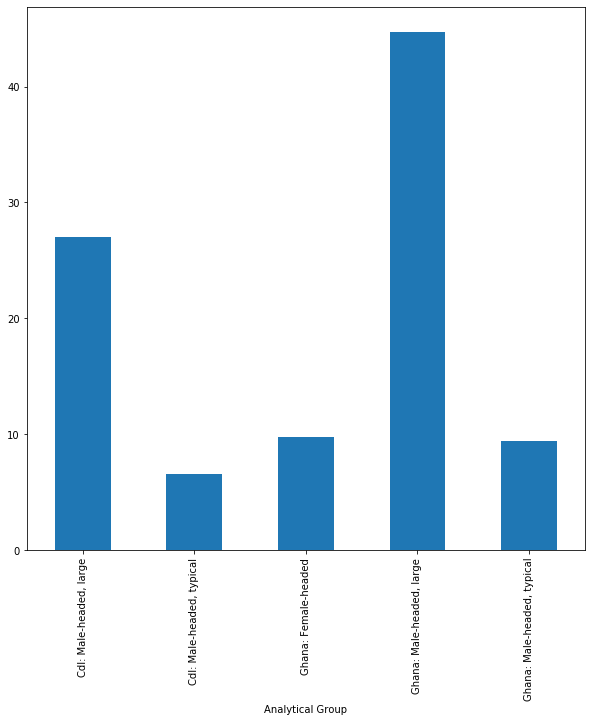

In [54]:
plt.figure(figsize=(10,10))
summary.plot.bar();

# 3 Prepare for Machine Learning

Now I want to buld a classifier that will predict if a farming household reaches or not the Living Income Benchmark.

The goal here is to have a model with as few variable as possible, which are likely to be either know by companies working with these farmers or relatevely easy to collect.

## 3.1 Feature Selection

I'll further select features by removing features that should not be used by the ML model or that have too many missing values to be used.

The goal is to predict if a farming household achieves the Living Income Benchmark, without knowing their total household income (if one would know the total household income, or be able to compute, there is no need for a classifier model).

There I'll drop all the calculated income variables I just built, plus the agregated and detailed costs of labour and inputs. I'll keep only indicator features of activities and sex and type of labor

In [56]:
data.drop([
    'Cocoa hired labour costs (USD/ha)',
    'Cocoa input costs (USD/ha)',
    'Estimated total household income (USD/household/year)',
    'Living Income Benchmark'
], axis = 1, inplace = True)

In [57]:
data.drop([
 'cocoa_landclear_hi_n_ha',
 'cocoa_landclear_hh_n_ha',
 'cocoa_landclear_com_n_ha',
 'cocoa_landclear_lab_n_ha',
 'cocoa_landclear_hi_lab_usdha',
 'cocoa_landprep_hi_n_ha',
 'cocoa_landprep_hh_n_ha',
 'cocoa_landprep_com_n_ha',
 'cocoa_landprep_lab_n_ha',
 'cocoa_landprep_hi_lab_usdha',
 'cocoa_planting_hi_n_ha',
 'cocoa_planting_hh_n_ha',
 'cocoa_planting_com_n_ha',
 'cocoa_planting_lab_n_ha',
 'cocoa_planting_hi_lab_usdha',
 'cocoa_gfert_hi_n_ha',
 'cocoa_gfert_hh_n_ha',
 'cocoa_gfert_com_n_ha',
 'cocoa_gfert_lab_n_ha',
 'cocoa_gfert_hi_lab_usdha',
 'cocoa_lfert_hi_n_ha',
 'cocoa_lfert_hh_n_ha',
 'cocoa_lfert_com_n_ha',
 'cocoa_lfert_lab_n_ha',
 'cocoa_lfert_hi_lab_usdha',
 'cocoa_manurecomp_hi_n_ha',
 'cocoa_manurecomp_hh_n_ha',
 'cocoa_manurecomp_com_n_ha',
 'cocoa_manurecomp_lab_n_ha',
 'cocoa_manurecomp_hi_lab_usdha',
 'cocoa_herb_hi_n_ha',
 'cocoa_herb_hh_n_ha',
 'cocoa_herb_com_n_ha',
 'cocoa_herb_lab_n_ha',
 'cocoa_herb_hi_lab_usdha',
 'cocoa_pest_hi_n_ha',
 'cocoa_pest_hh_n_ha',
 'cocoa_pest_com_n_ha',
 'cocoa_pest_lab_n_ha',
 'cocoa_pest_hi_lab_usdha',
 'cocoa_fung_hi_n_ha',
 'cocoa_fung_hh_n_ha',
 'cocoa_fung_com_n_ha',
 'cocoa_fung_lab_n_ha',
 'cocoa_fung_hi_lab_usdha',
 'cocoa_weed_hi_n_ha',
 'cocoa_weed_hh_n_ha',
 'cocoa_weed_com_n_ha',
 'cocoa_weed_lab_n_ha',
 'cocoa_weed_hi_lab_usdha',
 'cocoa_pruning_hi_n_ha',
 'cocoa_pruning_hh_n_ha',
 'cocoa_pruning_com_n_ha',
 'cocoa_pruning_lab_n_ha',
 'cocoa_pruning_hi_lab_usdha',
 'cocoa_harvest_hi_n_ha',
 'cocoa_harvest_hh_n_ha',
 'cocoa_harvest_com_n_ha',
 'cocoa_harvest_lab_n_ha',
 'cocoa_harvest_hi_lab_usdha',
 'cocoa_podbreak_hi_n_ha',
 'cocoa_podbreak_hh_n_ha',
 'cocoa_podbreak_com_n_ha',
 'cocoa_podbreak_lab_n_ha',
 'cocoa_podbreak_hi_lab_usdha',
 'cocoa_transport_hi_n_ha',
 'cocoa_transport_hh_n_ha',
 'cocoa_transport_com_n_ha',
 'cocoa_transport_lab_n_ha',
 'cocoa_transport_hi_lab_usdha',
 'cocoa_landclear_times',
 'cocoa_landclear_ha',
 'cocoa_landclear_hi_cost',
 'cocoa_landprep_times',
 'cocoa_landprep_ha',
 'cocoa_landprep_how_1',
 'cocoa_landprep_how_2',
 'cocoa_landprep_how_3',
 'cocoa_landprep_how_4',
 'cocoa_landprep_hi_cost',
 'cocoa_planting_times',
 'cocoa_planting_ha',
 'cocoa_planting_hi_cost',
 'cocoa_gfert_yn',
 'cocoa_gfert_hi_cost',
 'cocoa_lfert_times',
 'cocoa_lfert_given_yn',
 'cocoa_lfert_purchased_yn',
 'cocoa_lfert_given_pack',
 'cocoa_lfert_purchased_pack',
 'cocoa_lfert_pack_used_total',
 'cocoa_lfert_given_unitha',
 'cocoa_lfert_purchased_unitha',
 'cocoa_lfert_applied_unitha',
 'cocoa_lfert_usdha',
 'cocoa_lfert_hi_cost',
 'cocoa_manurecomp_times',
 'cocoa_manurecomp_hi_cost',
 'cocoa_herb_times',
 'cocoa_herb_given_yn',
 'cocoa_herb_purchased_yn',
 'cocoa_herb_given_pack',
 'cocoa_herb_purchased_pack',
 'cocoa_herb_pack_used_total',
 'cocoa_herb_given_unitha',
 'cocoa_herb_purchased_unitha',
 'cocoa_herb_applied_unitha',
 'cocoa_herb_usdha',
 'cocoa_herb_hi_cost',
 'cocoa_pest_times',
 'cocoa_pest_given_yn',
 'cocoa_pest_purchased_yn',
 'cocoa_pest_given_pack',
 'cocoa_pest_purchased_pack',
 'cocoa_pest_pack_used_total',
 'cocoa_pest_given_unitha',
 'cocoa_pest_purchased_unitha',
 'cocoa_pest_applied_unitha',
 'cocoa_pest_usdha',
 'cocoa_pest_hi_cost',
 'cocoa_fung_times',
 'cocoa_fung_given_yn',
 'cocoa_fung_purchased_yn',
 'cocoa_fung_given_pack',
 'cocoa_fung_purchased_pack',
 'cocoa_fung_pack_used_total',
 'cocoa_fung_given_unitha',
 'cocoa_fung_purchased_unitha',
 'cocoa_fung_applied_unitha',
 'cocoa_fung_usdha',
 'cocoa_fung_hi_cost',
 'cocoa_weed_times',
 'cocoa_weed_hi_cost',
 'cocoa_pruning_times',
 'cocoa_pruning_hi_cost',
 'cocoa_harvest_times',
 'cocoa_harvest_hi_cost',
 'cocoa_podbreak_times',
 'cocoa_podbreak_wait_days',
 'cocoa_podbreak_hi_cost',
 'cocoa_ferment_wait_days',
 'cocoa_ferment_material_1',
 'cocoa_ferment_material_2',
 'cocoa_ferment_material_3',
 'cocoa_ferment_material_4',
 'cocoa_ferment_material_5',
 'cocoa_ferment_material_999',
 'cocoa_ferment_material_99',
 'cocoa_transport_means',
 'cocoa_transport_times',
 'cocoa_transport_hi_cost',
 'cocoa_dry_wait_days',
 'cocoa_dry_material',
], axis = 1, inplace = True)

Lets also drop all yes/no questions which are only filters in the survey

In [58]:
data.drop(list(data.filter(regex = 'known_yn')), axis = 1, inplace = True)

Since these are all cocoa farmers, let's drop the question on most important crop

Let's first check if there is indeed little variation:

In [59]:
data['crops_important1'].value_counts()/len(df.index)*100

Cocoa                   92.425346
Cashews                  1.820830
Rubber                   1.602331
Palm                     1.019665
Rice                     0.728332
Plantain                 0.436999
Cassava                  0.291333
Maize                    0.291333
none/ not applicable     0.218500
Eggplant                 0.218500
Tomatoes                 0.218500
Pineapple                0.145666
Ginger                   0.145666
Chili                    0.072833
Coconut                  0.072833
Coffee                   0.072833
Groundnuts               0.072833
Other                    0.072833
Yam                      0.072833
Garlic                   0.000000
Cocoyam                  0.000000
Okra                     0.000000
Oranges                  0.000000
Papaya                   0.000000
Peppers                  0.000000
Cabbages                 0.000000
Beans                    0.000000
Avocado                  0.000000
Name: crops_important1, dtype: float64

In [60]:
data.drop(['crops_important1', 'crops_important1_5ago', 'crops_important2_5ago'], axis = 1, inplace = True)

## Investigate Missing values more in detail

In [69]:
 # check missing per variables:
share_missing = data.isnull().sum()/len(data.index)*100
share_missing.describe(percentiles = [.25, .5, .75, .90, .95, .99],)

count    703.000000
mean      25.839628
std       32.733014
min        0.000000
25%        0.000000
50%        2.257830
75%       56.445739
90%       78.295703
95%       91.332848
99%       99.708667
max       99.708667
dtype: float64

We see that there are variables with many missing values. 

Let's plot to confirm:

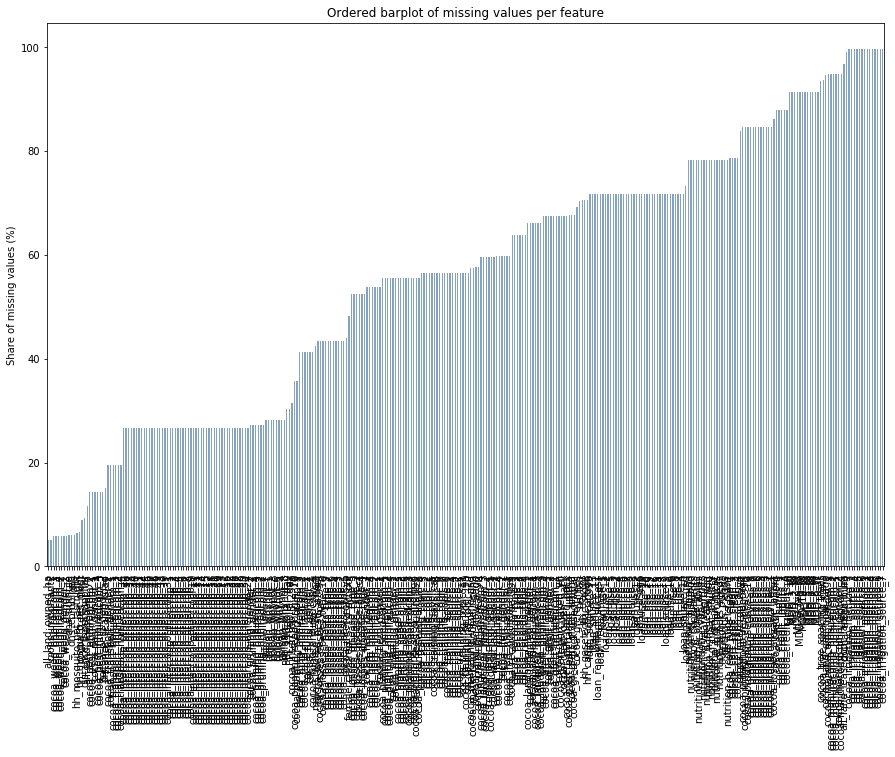

In [70]:
share_missing[share_missing>5].sort_values().plot.bar(figsize=(15,10), color=(0.2, 0.4, 0.6, 0.6))
plt.title("Ordered barplot of missing values per feature")
plt.ylabel("Share of missing values (%)")
plt.show()

Even though the graph is not readable, it confirms that some variables have many missing values.

Let's first take a look a the most problematic variables:

In [71]:
# problems:
problem = share_missing[share_missing>90]
print(len(problem), " problems")
list(problem.index)

37  problems


['all_land_leasedout_landunit_ha',
 'cocoa_trees_num',
 'cocoa_land_dec_how_5ago',
 'cocoa_tree_spacing_trees',
 'cocoa_tree_spacing_rows',
 'cocoa_manurecomp_hhhiredcom_1',
 'cocoa_manurecomp_hhhiredcom_2',
 'cocoa_manurecomp_hhhiredcom_3',
 'cocoa_manurecomp_hhhiredcom_4',
 'cocoa_manurecomp_gender_1',
 'cocoa_manurecomp_gender_2',
 'cocoa_irrigation_source_1',
 'cocoa_irrigation_source_2',
 'cocoa_irrigation_source_3',
 'cocoa_irrigation_source_4',
 'cocoa_irrigation_source_5',
 'cocoa_irrigation_source_6',
 'cocoa_irrigation_source_7',
 'cocoa_irrigation_method_1',
 'cocoa_irrigation_method_2',
 'cocoa_irrigation_method_3',
 'cocoa_irrigation_method_4',
 'cocoa_irrigation_method_5',
 'cocoa_irrigation_method_6',
 'cocoa_irrigation_method_7',
 'MDD_1_W',
 'MDD_2_W',
 'MDD_3_W',
 'MDD_4_W',
 'MDD_5_W',
 'MDD_6_W',
 'MDD_7_W',
 'MDD_8_W',
 'MDD_9_W',
 'MDD_10_W',
 'MDD_score_W',
 'MDD_bin_W']

We see from the above that the variables on irrigation source is missing (since no one irrigates cocoa). These can be droped. 

We see that the variables on tree numbers and spacing can also be dropped. Similar to all land leased out.

In [65]:
data.drop([ 
 'all_land_leasedout_landunit_ha',
 'cocoa_trees_num',
 'cocoa_land_dec_how_5ago',
 'cocoa_trees_distance_known_yn',
 'cocoa_tree_spacing_trees',
 'cocoa_tree_spacing_rows',], axis = 1, inplace = True)

Check that indeed (almost) no one irrigates cocoa:

In [66]:
data['cocoa_irrigation_yn'].value_counts()

no     1369
yes       4
Name: cocoa_irrigation_yn, dtype: int64

In [67]:
data.drop(list(data.filter(regex = 'irrigation')), axis = 1, inplace = True) 

The list also indicated that Minimum Dietary Diversity (MDD) variables is missing for most observations. This is by construction since these questions were asked only of female respondents. As much it is a potential good indicator, it is skipped for the majority of the sample, so we will drop those

In [72]:
data.drop(list(df.filter(regex='MDD')), axis = 1, inplace = True)
data.drop(list(df.filter(regex='nutrition')), axis = 1, inplace = True)

The list above also showed missing values for times, hh_hi and gender in manure application. This is likely because the application of manure was `no` for most farmers. Let's double check:

In [73]:
data['cocoa_manurecomp_yn'].value_counts()

no     1303
yes      70
Name: cocoa_manurecomp_yn, dtype: int64

In [74]:
data['cocoa_manurecomp_gender_1'].value_counts()

yes    64
no      6
Name: cocoa_manurecomp_gender_1, dtype: int64

This is indeed the case. Therefore we will impose `no` to all missing features related to `no` answer from a previous activity question

In [79]:
for activity in production_activities:
    data.loc[ data['cocoa_' + activity + "_yn"] == 'no', 'cocoa_' + activity + "gender_1"] = 0 

KeyError: 'cocoa_threshing_yn'

In [ ]:
def convert_tocodes(data, data_properties, label_name):
    
    columns = list(data.columns)
    for i in range(len(columns)):
        if data_properties.lbllist[i] == label_name:
            data[columns[i]] = data[columns[i]].cat.codes
            data.loc[data[columns[i]] == -1,columns[i]] = np.nan   
            
    return data
    

In [ ]:
data['head_gender']

In [ ]:
data = convert_tocodes(data, data_properties, "lblYESNO")
data = convert_tocodes(data, data_properties, "lblMALE_FEMALE")

In [ ]:
data.rename(columns =  data_properties.variable_labels(), inplace = True )

In [ ]:
data.head()

In [ ]:
list(data.columns)

In [ ]:
data['country'].value_counts()

Let's first revisit the full dictionary of features and full labels and remove the variables that are already dropped